## learning-AI101 : abalone classification
### 전복 데이터를 SVM, random forest, decision tree, logistic regression 기법을 적용하여 classification

<br>

- **임규연 (lky473736)**
- 2024.07.16. ~ 2024.07.18.에 문서 작성
- **dataset** : https://archive.ics.uci.edu/dataset/1/abalone
- **data abstract** : Predicting the age of abalone from physical measurements.  The age of abalone is determined by cutting the shell through the cone, staining it, and counting the number of rings through a microscope -- a boring and time-consuming task.  Other measurements, which are easier to obtain, are used to predict the age.  Further information, such as weather patterns and location (hence food availability) may be required to solve the problem. From the original data examples with missing values were removed (the majority having the predicted value missing), and the ranges of the continuous values have been scaled for use with an ANN (by dividing by 200).

------

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

-------

### 1. 데이터 EDA (탐색적 데이터 분석)

classification을 진행하기 전, 데이터 구조를 파악한다.

- **데이터 구조 파악 및 EDA**
    - 각 feature가 의미하는 바를 분석, 결측치 파악 후 어떻게 classification을 진행하는 것이 탁월할 지 파악
    - 각 feature에 대한 사분위수, mean, max, min, median, corr
    - seaborn을 통한 corr 상관관계 및 histplot 시각화
    - 각 feature에 대한 box plot 시각화
    - target의 도수를 bar plot 시각화

#### 1-1) 파일 열기, 기초 통계량 분석 및 classifiaction 전략 도출
현재 데이터의 파일 구조는 아래와 같다.
- abalone.data : 전복의 데이터를 담은 records들이 담긴 파일, header는 담기지 않음
- abalone.names : 본 데이터에 관한 설명이 담겨 있음
- index : 각 행의 index를 부여하기 위한 셸 스크립트
    
실질적인 데이터는 abalone.data 파일에 담겨 있으므로, 파일을 먼저 열어서 내용을 파악한 후 현재 데이터에 맞게끔 파일을 refactoring할 것이다.

In [48]:
# 파일 열기

file = open('data/abalone/abalone.data', 'r')
lines = file.readlines()
for line in lines[:5] : # 한 줄 단위로 
    print (line)
    
file.close()

M,0.455,0.365,0.095,0.514,0.2245,0.101,0.15,15

M,0.35,0.265,0.09,0.2255,0.0995,0.0485,0.07,7

F,0.53,0.42,0.135,0.677,0.2565,0.1415,0.21,9

M,0.44,0.365,0.125,0.516,0.2155,0.114,0.155,10

I,0.33,0.255,0.08,0.205,0.0895,0.0395,0.055,7



위를 보니, 현재 파일은 csv 형식으로, comma를 기준으로 각 component를 표현한 것으로 보인다. 따라서 **abalone.data의 확장자를 csv로 바꾼 뒤 EDA를 실시한다.**

In [49]:
# 파일의 확장자를 .data에서 .csv로 변경

import os

os.rename('data/abalone/abalone.data', 'data/abalone/abalone.csv')

In [50]:
# pandas를 이용하여 데이터프레임 불러오기

df = pd.read_csv ('data/abalone/abalone.csv')
df.head()   

,M,0.455,0.365,0.095,0.514,0.2245,0.101,0.15,15
0,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
1,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
2,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
3,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7
4,I,0.425,0.300,0.095,0.3515,0.1410,0.0775,0.120,8


위를 확인하니, header가 존재하지 않아 attribute을 통한 접근이 불가능하다. 따라서 abalone.names에 나와있는 **본 데이터의 attribute인 Sex, Length, Diameter, Height, Whole_weight, Shucked_weight, Viscera_weight, Shell_weight, Rings을 본 df 위에 삽입**한다. 

<br>

먼저 header를 삽입하기 전, abalone.names에 언급되는 각 attribute가 의미하는 바는 아래와 같다.

- **Sex** (성별)
  - **Data Type**: nominal (명목형)
  - **Meas.**: M, F, and I (infant) (M, F, 그리고 I(유아))
  - **Description**: 성별 (M은 남성, F는 여성, I는 유아)

- **Length** (길이)
  - **Data Type**: continuous (연속형)
  - **Meas.**: mm (밀리미터)
  - **Description**: 가장 긴 껍질의 측정값

- **Diameter** (직경)
  - **Data Type**: continuous (연속형)
  - **Meas.**: mm (밀리미터)
  - **Description**: 길이에 수직인 직경

- **Height** (높이)
  - **Data Type**: continuous (연속형)
  - **Meas.**: mm (밀리미터)
  - **Description**: 껍질 안에 고기가 있는 상태의 높이

- **Whole weight** (전체 무게)
  - **Data Type**: continuous (연속형)
  - **Meas.**: grams (그램)
  - **Description**: 전체 전복의 무게

- **Shucked weight** (껍질을 벗긴 무게)
  - **Data Type**: continuous (연속형)
  - **Meas.**: grams (그램)
  - **Description**: 고기의 무게

- **Viscera weight** (내장 무게)
  - **Data Type**: continuous (연속형)
  - **Meas.**: grams (그램)
  - **Description**: 피를 뺀 후의 내장 무게

- **Shell weight** (껍질 무게)
  - **Data Type**: continuous (연속형)
  - **Meas.**: grams (그램)
  - **Description**: 건조된 후의 껍질 무게

- **Rings** (나이)
  - **Data Type**: integer (정수형)
  - **Meas.**: 없음
  - **Description**: +1.5를 더하면 나이를 년 단위로 나타냄

이때 Ring column이 target이 되고, 나머지를 feature로 구성한다. 각 특성을 조합하여 모델을 구성하고, 입력 데이터에 따른 전복의 나이를 classification할 것이다. 하지만 우려되는 건, 나이를 classification하는 것이기 때문에 특정 나이대에만 데이터가 쏠려 샘플링 편향이 발생할 수도 있으니 추후 train_test_split을 진행 시에 stratify 파라미터를 설정하여 편향을 막는 것이 좋겠다.

In [51]:
# attribute를 header에 삽입하여 다시 df를 구성 

attributes = ['Sex', 'Length', 'Diameter', 'Height', 'Whole_weight', 
                'Shucked_weight', 'Viscera_weight', 'Shell_weight', 
                'Rings']
df = pd.read_csv('data/abalone/abalone.csv', header=None, 
                 names=attributes)

df.head()

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [52]:
# df의 행의 갯수, 열의 갯수, feature 파악

df.shape, df.columns

((4177, 9),
 Index(['Sex', 'Length', 'Diameter', 'Height', 'Whole_weight', 'Shucked_weight',
        'Viscera_weight', 'Shell_weight', 'Rings'],
       dtype='object'))

In [53]:
# df의 기본적인 통계량 수치 파악, 각 열마다 결측치 여부 파악

for feature in df.columns :
    print (f'{feature}의 데이터 타입 : ', df[feature].dtype)

df.describe()

Sex의 데이터 타입 :  object
Length의 데이터 타입 :  float64
Diameter의 데이터 타입 :  float64
Height의 데이터 타입 :  float64
Whole_weight의 데이터 타입 :  float64
Shucked_weight의 데이터 타입 :  float64
Viscera_weight의 데이터 타입 :  float64
Shell_weight의 데이터 타입 :  float64
Rings의 데이터 타입 :  int64


,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831,9.933684
std,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203,3.224169
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000,8.000000
50%,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000,9.000000
75%,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000,11.000000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


classification 전략을 세우자면 아래와 같다.

- **classification 전략**
    - 학습 전에 데이터를 아래와 같이 준비
        - 특성 변수 (feature) : Sex, Length, Diameter, Height, Whole_weight, Shucked_weight, Viscera_weight, Shell_weight
        - 타겟 변수 (target) : Rings
    - SVM, logistic regression 전에 스케일링 필요
    - 또한, Sex 열이 현재 문자열로 이루어져 있어서 encoding을 거치는 것이 좋겠음
    
-------

#### 1-2) seaborn을 통한 상관관계 heatmap 및 전체 histplot 시각화
- 시각화 전, Sex 열을 먼저 encoding한다.

In [54]:
# Sex 열을 encoding
# M(Male) -> 0
# F(Female) -> 1
# I(Infant) -> 2

encoding_map = {'M': 0, 'F': 1, 'I': 2}

# Sex 열 인코딩
df['Sex'] = df['Sex'].map(encoding_map)

df['Sex'].head()  

0    0
1    0
2    1
3    0
4    2
Name: Sex, dtype: int64

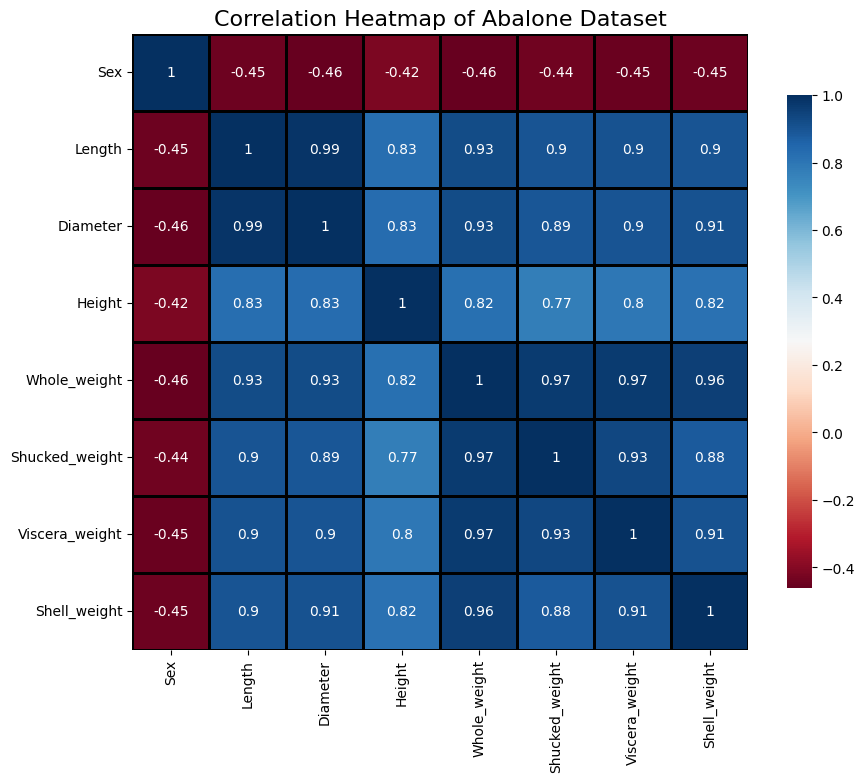

In [55]:
# seaborn을 통하여 heatmap 시각화
# 상관계수 행렬, 각 변수 간의 선형적 관계를 시각적으로 표시

correlation_matrix = df[['Sex', 'Length', 'Diameter', 'Height', 
                         'Whole_weight', 'Shucked_weight', 
                         'Viscera_weight', 'Shell_weight']].corr() # feature (target 제외)
plt.figure(figsize=(10, 8)) 
sns.heatmap(correlation_matrix, annot=True, cmap='RdBu', square=True,
            linewidths=1, linecolor='black', cbar_kws={"shrink": 0.8})

plt.title('Correlation Heatmap of Abalone Dataset', fontsize=16)
plt.show()

위 heatmap는 음수로 갈 수록 음의 상관관계(반비례), 양수로 갈 수록 양의 상관관계(정비례)를 의미한다. 또한 diagonal을 중심으로 각 part가 대칭이다. (symmetric) figure를 보고 주목해야 할 부분은 아래와 같이 분석할 수 있다.

- **높은 상관관계**
     - **Length와 Diameter (0.99)**
       - 매우 높은 양의 상관관계, Length와 Diameter는 거의 일치

    - **Length와 Whole weight (0.93)**, **Diameter와 Whole weight (0.93)**:
       - 길이와 직경, 무게가 매우 높은 상관관계, 이를 통하여 길이랑 직경이 크면 무게도 무겁다는 것을 예측 가능

    - **Whole weight와 Shucked weight (0.97)**, **Whole weight와 Viscera weight (0.97)**:
       - 전복의 전체 무게는 껍질을 벗긴 무게와 내장 무게와 매우 높은 상관관계를 가지므로, 전체 무게가 부분 무게들에 의해 크게 좌우되는 것을 예측 가능

    - **Shucked weight와 Viscera weight (0.93)**:
       - 두 무게가 함께 증가하거나 감소하는 경향 있음

    - **Length와 Shell weight (0.9)**, **Diameter와 Shell weight (0.91)**:
       - 전복의 길이와 직경은 껍질 무게와도 높은 상관관계 보임

- **낮은 상관관계**  
    - **Sex와 다른 변수들**
       - 성별은 다른 연속형 변수들과 음의 상관관계를 가지며, 특히 높이는 -0.42, 껍질 무게는 -0.45로 나타남, 이는 성별이 전복의 다른 물리적 특성과 직접적으로 큰 관련이 없음을 나타냄
       
추후 logistic regression 시 상관관계가 낮은 Sex 특성을 제거해도 score에 큰 영향이 가지 않는지를 탐구할 예정이다. 


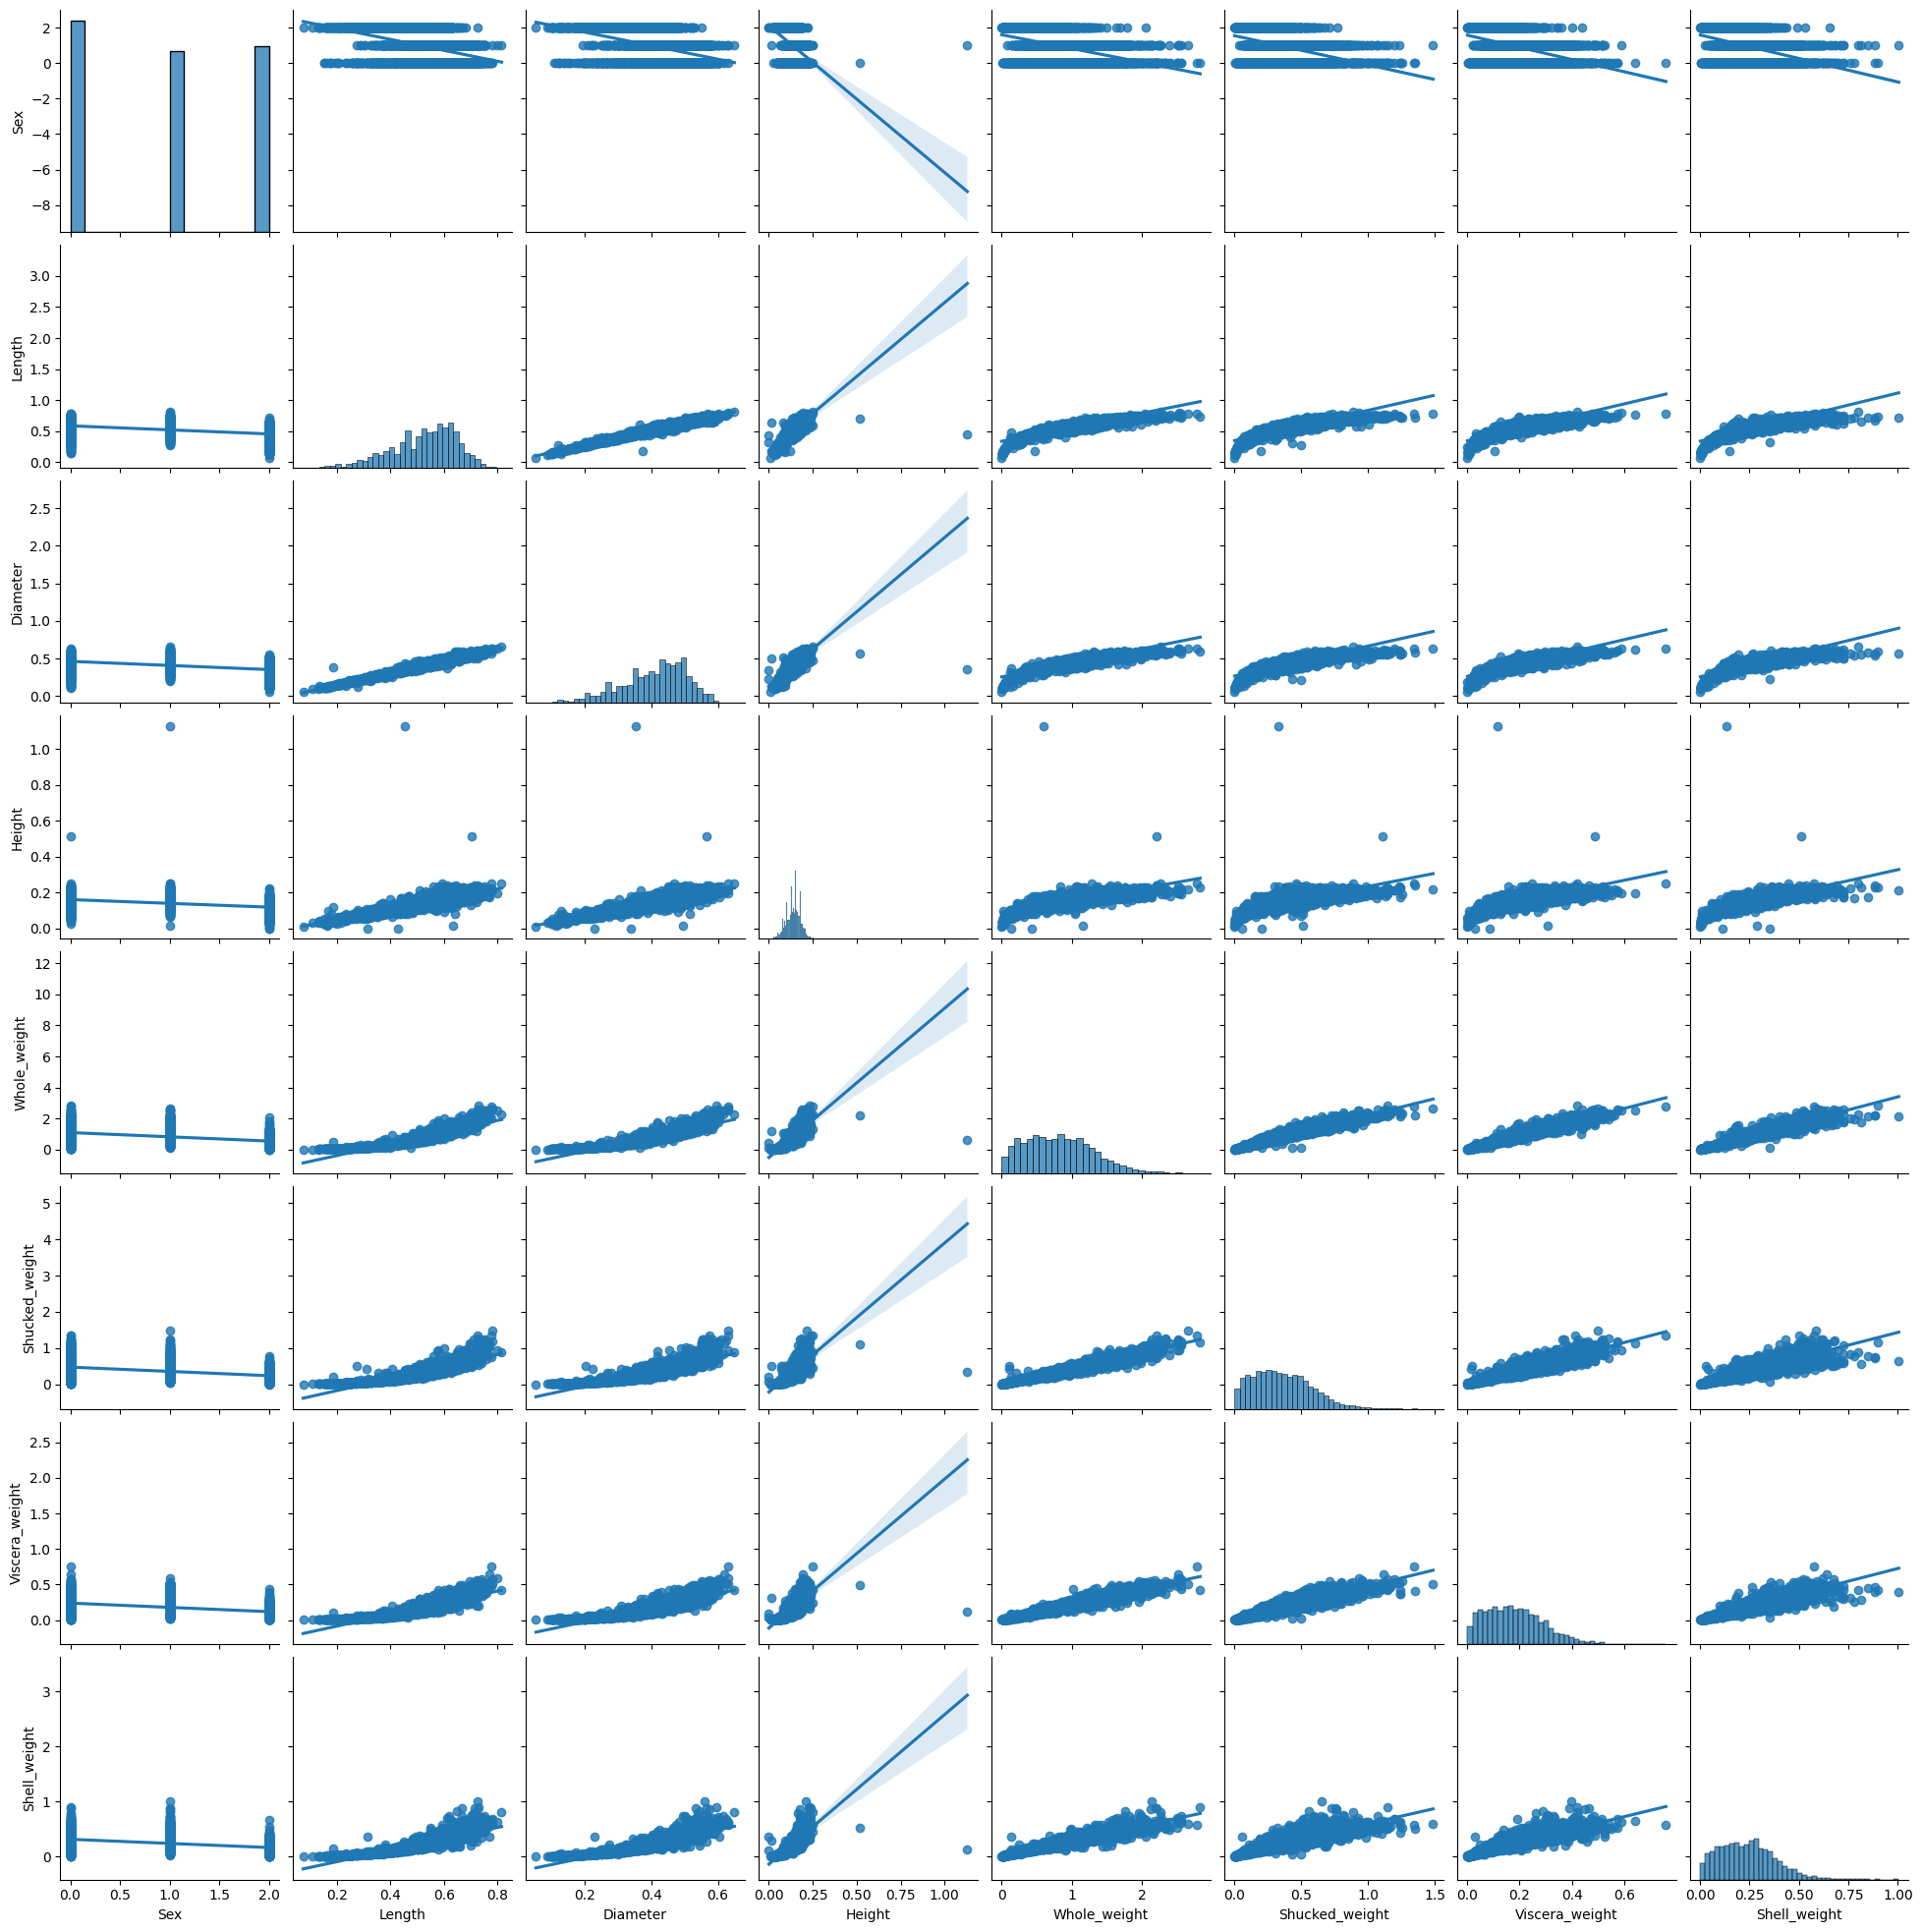

In [56]:
# seaborn을 통하여 pairplot 시각화
# 현재 데이터프레임의 모든 열 쌍에 대한 산점도와 히스토그램을 시각화한다

sns.pairplot(df[['Sex', 'Length', 'Diameter', 'Height', 
                         'Whole_weight', 'Shucked_weight', 
                         'Viscera_weight', 'Shell_weight']], kind="reg") # feature (target 제외)
plt.show()

------

#### 1-3) 각 feature에 대한 box plot 시각화



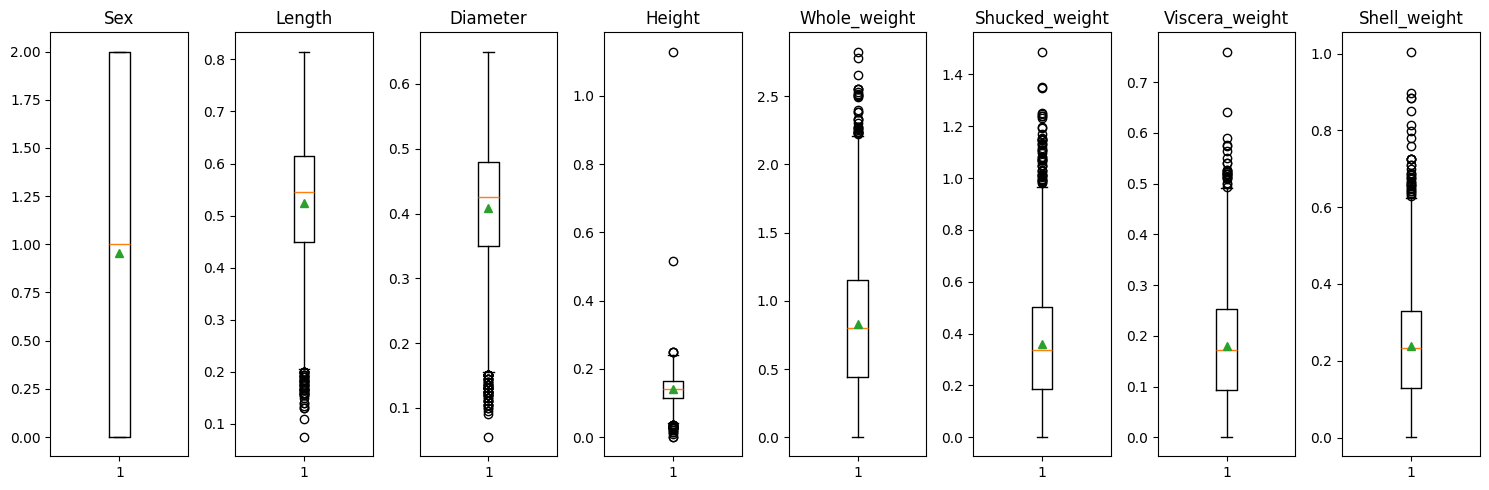

In [57]:
# box plot 그려 데이터 분포 확인

attr_list = ['Sex', 'Length', 'Diameter', 'Height', 
                         'Whole_weight', 'Shucked_weight', 
                         'Viscera_weight', 'Shell_weight']

# subplot 생성
fig, axes = plt.subplots(nrows=1, ncols=len(attr_list), figsize=(15, 5))

# 각 변수에 대한 boxplot 그리기
for i, var in enumerate(attr_list) :
    ax = axes[i]
    ax.boxplot(df[var], showmeans=True)
    ax.set_title(var)

plt.tight_layout()
plt.show()

------

#### 1-4) target의 갯수를 bar plot으로 시각화



In [58]:
# bar plot 그려 target의 Rings 도수를 파악
# 도수를 알기 위해 unique 매소드 사용

target = np.unique(df['Rings'])
print (target)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 29]


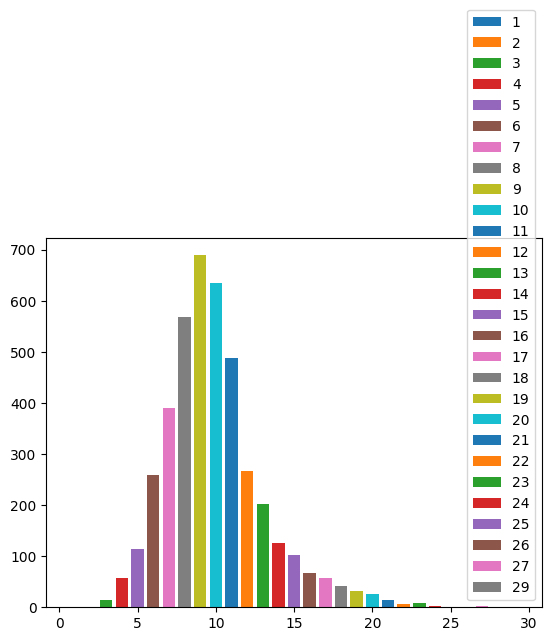

In [59]:
# 시각화 진행

for compo in target : 
    plt.bar(compo, len(df[df['Rings'] == compo]), label=compo)
    
plt.legend()
plt.show()

위 bar plot을 확인해보니, 정규분포의 모양을 띄며 Rings 데이터들이 9~10을 평균 삼아 분포가 구성되는 것을 알 수 있다. 하지만 도수가 불균형하여 추후 샘플링 편향이 발생할 것으로 예측되기 때문에, train_test_split 시 stratify 파라미터를 설정하여 편향을 막는 것이 좋겠다.

------

### 2. 데이터 전처리

1에서 분석한 바를 토대로 전처리를 진행한다.
- **전처리**
    - 결측치는 그 feature (열)의 평균으로 fill
    - encoding을 통한 Sex 특성 전처리 (이미 진행 완료)
    - 만약 scale이 많이 다르다면 Z-score normalization 진행 

#### 2-1) 결측치 확인 및 fill 

In [60]:
# 결측치 확인

for feature in df.columns :
    print (f'{feature}열의 결측치 존재 여부 : ', df[feature].isnull())
    print ('\n--------------\n')

print ("데이터의 총 결측치 수 : ", df.isnull().sum())

Sex열의 결측치 존재 여부 :  0       False
1       False
2       False
3       False
4       False
        ...  
4172    False
4173    False
4174    False
4175    False
4176    False
Name: Sex, Length: 4177, dtype: bool

--------------

Length열의 결측치 존재 여부 :  0       False
1       False
2       False
3       False
4       False
        ...  
4172    False
4173    False
4174    False
4175    False
4176    False
Name: Length, Length: 4177, dtype: bool

--------------

Diameter열의 결측치 존재 여부 :  0       False
1       False
2       False
3       False
4       False
        ...  
4172    False
4173    False
4174    False
4175    False
4176    False
Name: Diameter, Length: 4177, dtype: bool

--------------

Height열의 결측치 존재 여부 :  0       False
1       False
2       False
3       False
4       False
        ...  
4172    False
4173    False
4174    False
4175    False
4176    False
Name: Height, Length: 4177, dtype: bool

--------------

Whole_weight열의 결측치 존재 여부 :  0       False
1       False
2       False


위를 보면, 본 데이터에 결측치가 **전혀** 존재하지 않고 있다. 따라서 결측치에 따른 전처리를 진행하지 않아도 된다.

#### 2-2) 정규화 (normalization) - Z-score normalization
- 각 feature의 scale이 서로 달라, SVM, logistic regression 전에 StandardScaler를 통한 스케일링이 필요
- 따라서 StandardScaler를 통한 Z-score normalization을 수행

In [61]:
# input과 target으로 df를 split

abalone_input = df[attr_list].to_numpy() 
abalone_target = df['Rings'].to_numpy()

In [62]:
# X_train, y_train, X_test, y_test으로 train set, test set 각각 8:2로 split

from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(abalone_input, abalone_target, 
                                                   stratify=abalone_target, 
                                                   test_size=0.2)

ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

위와 같은 에러가 발생한 이유는, component가 1개거나 0개인 특정 클래스들은 공정한 split이 불가하기 때문에 그렇다. (https://www.kaggle.com/code/vaasha/stratified-test-train-split 참고) 본 문제의 원인을 파악하기 위해 아래와 같은 코드를 작동한다. 

In [63]:
# abalone_target의 각 클래스별 개수 확인

unique, counts = np.unique(abalone_target, return_counts=True)
class_counts = dict(zip(unique, counts))
print(class_counts)

{1: 1, 2: 1, 3: 15, 4: 57, 5: 115, 6: 259, 7: 391, 8: 568, 9: 689, 10: 634, 11: 487, 12: 267, 13: 203, 14: 126, 15: 103, 16: 67, 17: 58, 18: 42, 19: 32, 20: 26, 21: 14, 22: 6, 23: 9, 24: 2, 25: 1, 26: 1, 27: 2, 29: 1}


In [64]:
# abalone_target에서 1, 2, 25, 26, 29 삭제 후 다시 split 시도

# abalone_target에서 특정 클래스 삭제
del_classes = [1, 2, 25, 26, 29]
indices_to_keep = ~np.isin(abalone_target, del_classes)

# 데이터 일치화 후 재할당
abalone_input = abalone_input[indices_to_keep]
abalone_target = abalone_target[indices_to_keep]

from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(abalone_input, abalone_target, 
                                                   stratify=abalone_target, 
                                                   test_size=0.2)

In [65]:
# StandardScaler을 통한 정규화 진행

from sklearn.preprocessing import StandardScaler
ss_transformer = StandardScaler()

ss_transformer.fit(X_train)

X_train_scaled = ss_transformer.transform(X_train)
X_test_scaled = ss_transformer.transform(X_test)

-------

### 3. 각종 모델을 적용하여 classification
- SVM, random forest, decision tree, logistic regression 기법을 적용하여 classification
- 순서는 logistic regression, decision tree, random forest, SVM

#### 3-1) KNN